In [32]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.style import set_palette

import os, shutil, joblib

import upsilon

list_cephs = os.listdir('../csv_data/LMC/cep_2k/I/')
list_bin = os.listdir('../csv_data/LMC/bin_2k/I/')[:len(list_cephs)]
list_lyr = os.listdir('../csv_data/LMC/rrlyr_2k/I/')[:len(list_cephs)]

train_cephs, test_cephs = train_test_split(list_cephs, train_size = 0.7)
train_bin, test_bin = train_test_split(list_bin, train_size = 0.7)
train_lyr, test_lyr = train_test_split(list_lyr, train_size = 0.7)

plt.style.use('fast')
set_palette('flatui')

# Variable Stars Classification. Use case for random forests

### Contents

1. Introduction
2. Data preparation and feature extraction
3. Model training
   - Prerequisets
   - Training
4. Testing and validation
5. Conclusion
6. References

## 1. Introduction

Here I give an overview of my project, mentioning quickly key moments in every main section that is yet to come.

This project aims to classify variable stars from the Large Magellanic Cloud (LMC) using photometric data from the OGLE Collection of Variable Stars. The project focuses on three classes of variable stars: Classical Cepheids (CEPs), Eclipsing and Binary Stars (ECLs) and RR Lyrae (RRLYRs). The data for these classes was extracted from the LMC using the UPSILoN library.

The main objectives of the project are to:

* Extract photometric features from the time series data for the classes.
* Train a classifier on the data
* Evaluate the performance of the model on unseen data.

**Data preparation and feature extraction**

The data for this project was obtained from the [OGLE Collection of Variable Stars](https://ogledb.astrouw.edu.pl/~ogle/OCVS/). The data was downloaded as three archived files. Each archive file contains two folders, one for near-infrared (I-band) data and one for visible (V-band) data. The I-band data was used for this project because it has more objects.

The data for each object is stored in a separate `.dat` file. Each `.dat` file contains time series data for the object, including its magnitude and error. The data was extracted from the `.dat` files using the UPSILoN library.

**Feature Extraction**

The UPSILoN library was used to extract the following features from the time series data:

* Kurtosis
* Skewness
* Number of points
* Height-to-length amplitude ratio
* Period signal-to-noise ratio
* Phase eta
* Stetson K
* Weighted mean
* Quartile 31
* Shapiro-Wilk W statistic
* R21 correlation coefficient
* Period
* R31 correlation coefficient
* Slope per 90 points
* Phase cusum
* Amplitude
* Slope per 10 points
* Period uncertainty
* Weighted standard deviation
* Cusum
* Eta
* Period logarithmic false alarm probability
* Phi21 correlation coefficient
* Phi31 correlation coefficient

**Model taining**

A Random Forest classifier was used to classify CEPs, ECLs and RRLYRs. This classifier was chosen because it is able to learn to classify complex data and it can classify multiple classes.

The data has been preprocessed into different data sets for training, testing and validation.

**Testing and validation**

The performance of the model was evaluated using the following metrics:

* Accuracy
* Recall
* Precision
* F1-score
* ROC AUC

## 2. Data preparation and feature extraction

In this section we will discuss how to the data has been gathered, processed (prepared) and how the light-curve features have been extracted. 

The data pre-process pipeline:
    - Gather data from catalogue
    - Feature extraction using UPSILoN
    - Saving into one large dataset

First we start with data extraction and preparation.

### Data prep:


The topics to be covered in this subsection are:
- From where the data has been gathered
- How and why it has been processed
- How and why were the features extracted

The data has been gathered from the [OGLE Collection of Variable Stars](https://ogledb.astrouw.edu.pl/~ogle/OCVS/) which is a catalogue of light-curve data sampled from observations of the Galactic bulge, Galactic disk and Magellanic Clouds.

In it it has data for:
- Classical Cepheids: LMC SMC BLG GD
- Anomalous Cepheids: LMC SMC GAL
- Type II Cepheids: LMC SMC BLG GD
- RR Lyrae: LMC SMC BLG GD
- Long Period Variables (Miras): BLG GD
- delta Scuti: LMC SMC BLG GD
- Heartbeat Stars: LMC SMC BLG
- Transiting Planets: BLG
- Eclipsing and Binary Stars: LMC SMC BLG

We will extract the data for three of those classes: Classical Cepheids (CEPs), RR Lyrae and Eclipsing and Binary Stars (ECLs) from the Large Magellanic Cloud (LMC). The reason for choosing three classes is sufficient number of samples in the LMC group

The downloaded data is an archived file (in our case we have three archives, since we have three classes to download). In it we have three folders in which the data is located. Folder one, labelled I stands, for near-infrared spectrum, folder two, labelled V, stands for visible spectrum. Folder I has more objects than V, so we will use that.

Once we have downloaded the three archives the files have been located in `../csv_data/LMC/` in which we have, again, three folders: bin and cep for the two classes and rrl for the third class. In every one of these folder we have another two folders with the data from different filters. As said, we choose I.

As one can see the extension for every file is .dat, which is easily opened with with_open() and then with pandas.read_table(). So knowing this we will create a function data_extraction() that takes a list with the .dat files which we will name src, the directory of those files (src_dir) and the object class (object_class). The function consists of a for loop that iterates over the list of objects (src), opens them one by one, extracts features (more on that in a bit), sets id and class for the object and saves the sample as a DataFrame object in a list called records. After calling the function we get a list of DataFrame objects that we can call concat() so the merge them into one final DataFrame.

I mentioned that we use .dat files. In every such file there is time series data for every recorded object with its magnitude and error. During my work on the project I struggled to process the data into a form, that can be correctly classified. Because of that I turned my head towards the UPSILoN library created by [Kim & Bailer-Jones](http://arxiv.org/abs/1512.01611) in 2015. UPSILoN has a function that extracts features from time series data, mainly: kurtosis, skewness, n_points, hl_amp_ratio, period_SNR, phase_eta, stetson_k, weighted_mean, quartile31, shapiro_w, r21, period, r31, slope_per90, phase_cusum, amplitude, slope_per10, period_uncertainty, weighted_std, cusum, eta, period_log10FAP, phi21, and phi31. We won't use `period_log10FAP`, since for some reason that I couldn't find the function gets division by zero warning while calculating this feature.

We also will use only the first 30% of every time series to avoid training our model on data in the future. This is achieved with `train_test_split(data, train_size = 0.3, shuffle = False)`, where we take the first 30% as our train set and the rest we will use to validate. If we don't want to create a train set we can set `validation_sample` to `False`, which is already on by default, to have just one dataframe. We also set `shuffle` to `False` since we don't want random days of the month, but the first couple of ones. 

The reason I use percentages and not some value that indicates how many days I will take, is that the time series have different lengths and by using percentages I make sure to not take too many days off.
> In general it is always good to have some kind of normalization. In this case this transformation doesn't yield any effect (positive or negative), but I have used in the spirit of good practice in the model training phase.



In [2]:
def data_extraction(src: list, src_dir: str, object_class: str, validation_sample = False):
    # Set a list to store the samples for every object
    records = []
    records_val = []

    # For every file in a list of files (src), access it
    for file in src:

        # Set file path to then open light-curves 
        file_path = src_dir + file
        
        # Open .dat light-curve file
        with open(file_path, 'r') as f:

            # Create a DataFrame object with the data to more easily modify it later
            data = pd.read_table(f, delim_whitespace=True, names=["HJD-2450000", 'mag', 'err'])

            # Filter empty files
            if not data.empty and len(data) > 30:
                X_train, X_val = train_test_split(data, train_size = 0.3, shuffle = False)
                
                # Rename time column
                X_train = X_train.rename(columns={"HJD-2450000": "time"})
                X_train = X_train.sort_values(by = 'time')

                # Convert the columns to NumPy arrays
                time = X_train['time'].to_numpy()
                mag = X_train['mag'].to_numpy()
                err = X_train['err'].to_numpy()

                # Create an ExtractFeatures object and extract features
                e_features = upsilon.ExtractFeatures(time, mag, err)
                e_features.run()
                features = e_features.get_features()

                # Create a DataFrame with features and class
                feature_data = pd.DataFrame.from_dict(features, orient = 'index').T.drop(columns=['period_log10FAP'])

                feature_data['id'] = file
                feature_data['class'] = object_class
                # Append to the list of DataFrames
                records.append(feature_data)

                # Validation
                X_val = X_val.rename(columns={"HJD-2450000": "time"})
                X_val = X_val.sort_values(by = 'time')

                time_val = X_val['time'].to_numpy()
                mag_val = X_val['mag'].to_numpy()
                err_val = X_val['err'].to_numpy()

                # Create an ExtractFeatures object and extract features
                e_features_val = upsilon.ExtractFeatures(time_val, mag_val, err_val)
                e_features_val.run()
                features_val = e_features_val.get_features()

                # Create a DataFrame with features and class
                feature_data_val = pd.DataFrame.from_dict(features_val, orient = 'index').T.drop(columns=['period_log10FAP'])

                feature_data_val['id'] = file
                feature_data_val['class'] = object_class
                # Append to the list of DataFrames
                records_val.append(feature_data_val)

    if validation_sample:
        return pd.concat(records), pd.concat(records_val)
    else:
        return pd.concat(records)


I have already precomputed the dataset, so here is a test set just to show it is working. The dataset is balanced to avoid underrepresentation for one of the two classes (cepheids). 

> Note: An error occurs since the data points in the time series data of some objects is less than 80 and so the devs say accuracy for classification will be lower. We don't use classification though, so ignoring the warning wont cause any harm.

In [6]:
# Call the data_extraction function to extract data for Cepheid stars
# src: list of Cepheid stars 
# src_dir: directory path where the Cepheid data files are located
# object_class: class label for Cepheids
cephs_train_dummy, cephs_val_dummy = data_extraction(src=test_cephs[:10], src_dir='../csv_data/LMC/cep_2k/I/', object_class='Cepheid',
                                        validation_sample = True)

# Call the data_extraction function to extract data for Binary stars
# src: list of Binary stars 
# src_dir: directory path where the Binary data files are located
# object_class: class label for Binary stars

bin_train_dummy, bin_val_dummy = data_extraction(src=test_bin[:10], src_dir='../csv_data/LMC/bin_2k/I/', object_class='Binary',
                                     validation_sample = True)

lyr_train, lyr_val_dummy = data_extraction(src=test_lyr[:10], src_dir='../csv_data/LMC/rrlyr_2k/I/', object_class='Lyrae',
                                     validation_sample = True)

# Concatenate the data extracted for Cepheids and Binary stars into a single DataFrame
train_df_dummy = pd.concat([cephs_train_dummy, bin_train_dummy, lyr_train], ignore_index=True)
val_df_dummy = pd.concat([cephs_val_dummy, bin_val_dummy, lyr_val_dummy], ignore_index=True)

c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'


In [10]:
val_df_dummy.head()

,amplitude,cusum,eta,hl_amp_ratio,kurtosis,n_points,period,period_SNR,period_uncertainty,phase_cusum,...,r31,shapiro_w,skewness,slope_per10,slope_per90,stetson_k,weighted_mean,weighted_std,id,class
0,0.133414,0.036449,1.329233,1.420642,-1.275012,515.0,7.982533,107.596297,0.075423,0.220862,...,0.067413,0.893742,0.318857,-7.857235,10.992881,0.849189,14.165311,0.100398,OGLE-LMC-CEP-1364.dat,Cepheid
1,0.105917,0.052162,1.935700,0.715777,-1.293213,467.0,1.323611,102.065200,0.002047,0.220711,...,0.030192,0.935481,-0.205754,-1.234362,1.110927,0.857628,16.242109,0.077333,OGLE-LMC-CEP-1197.dat,Cepheid
2,0.106309,0.055716,2.607387,0.716806,-1.315313,466.0,2.669170,100.287177,0.007677,0.228813,...,0.097301,0.927139,-0.227164,-2.714656,1.892718,0.860073,16.182375,0.079694,OGLE-LMC-CEP-0345.dat,Cepheid
3,0.136777,0.074023,2.371921,0.647580,-1.440612,241.0,1.585874,74.951262,0.002871,0.238286,...,0.065643,0.884974,-0.283588,-1.470736,2.508493,0.880814,15.438263,0.105328,OGLE-LMC-CEP-0913.dat,Cepheid
4,0.176761,0.139690,1.779729,1.297420,-1.497367,64.0,4.057762,25.524383,0.008948,0.270839,...,0.202607,0.896019,0.144701,-5.417927,5.909491,0.887375,15.218609,0.167780,OGLE-LMC-CEP-0278.dat,Cepheid


In [11]:
train_df_dummy.head()

,amplitude,cusum,eta,hl_amp_ratio,kurtosis,n_points,period,period_SNR,period_uncertainty,phase_cusum,...,r31,shapiro_w,skewness,slope_per10,slope_per90,stetson_k,weighted_mean,weighted_std,id,class
0,0.135302,0.046596,1.204376,1.569341,-1.361883,220.0,7.985403,52.453059,0.254570,0.237688,...,0.093025,0.883863,0.299109,-9.263732,11.283253,0.851650,14.169418,0.100708,OGLE-LMC-CEP-1364.dat,Cepheid
1,0.104179,0.056322,2.263380,0.776957,-1.403495,199.0,1.323931,48.300312,0.008191,0.216807,...,0.038857,0.920490,-0.109336,-2.241392,2.761791,0.867623,16.238544,0.078391,OGLE-LMC-CEP-1197.dat,Cepheid
2,0.105915,0.053493,2.742199,0.711192,-1.397702,199.0,2.670094,48.867445,0.033534,0.239006,...,0.084367,0.909895,-0.224078,-4.477128,8.797109,0.862064,16.180688,0.081808,OGLE-LMC-CEP-0345.dat,Cepheid
3,0.142574,0.074800,2.505443,0.725084,-1.437985,102.0,1.585592,35.949117,0.005285,0.247074,...,0.076021,0.882728,-0.288585,-3.957318,4.238285,0.874379,15.433868,0.106291,OGLE-LMC-CEP-0913.dat,Cepheid
4,0.181485,0.116005,2.378098,1.320973,-1.077222,27.0,4.056583,9.419274,0.018580,0.259754,...,0.290639,0.926521,0.377522,-3.896219,12.454656,0.826937,15.207852,0.148579,OGLE-LMC-CEP-0278.dat,Cepheid


It is important to show feature importances with `PCA`:

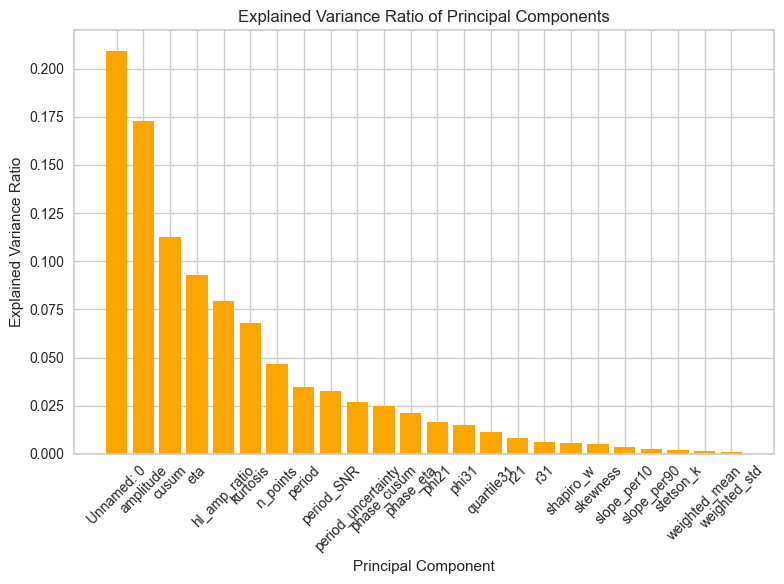

[0.20943797 0.38204602 0.49472119 0.58780853 0.66718586 0.73494672
 0.78154869 0.81602605 0.84854524 0.87561511 0.90032597 0.92129128
 0.93777479 0.95294411 0.96413603 0.97253835 0.97890477 0.98435143
 0.98917979 0.99273368 0.99544042 0.99747606 0.99901341 1.        ]


PCA()

In [3]:
def visualize_pca(df):
    # Assuming 'df' is your DataFrame with features

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:, :-1])

    # Perform PCA
    pca = PCA()
    pca.fit_transform(scaled_data)

    # Explained variance ratios
    explained_var = pca.explained_variance_ratio_

    # Plot explained variance ratios
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_var) + 1), explained_var, align='center', color='orange')

    # Set feature names as x-axis ticks
    plt.xticks(range(1, len(explained_var) + 1), df.columns[:-1], rotation=45)  # Assuming last column is the target

    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.tight_layout()
    plt.show()
    print(explained_var.cumsum())
    return pca

# Load the DF and call PCA
df = pd.read_csv('../csv_data/test/test_df_lyr.csv')
features = df.drop(columns = ['id', 'class'])
labels = df.pop('class')
df.shape, np.unique(labels)
visualize_pca(df)

The first 10 features cover about 90% of the information. Knowing this the I would have discarded the remainder of the features when **extracting** them, since this took the majority of computational time. In the future I would do exactly that.

Let's now go to training

## 3. Model training

Here I will describe my decisions for choosing a specific model. Section 4. is more interesting!


The `load_df` function reads a CSV file into a df, removes unnecessary columns, normalizes the features and labels, and returns standardized features, encoded labels, and title of the CSV file.

In [5]:
def load_df(df_src: str):
    load_df = pd.read_csv(df_src)
    df = load_df.sample(frac=1)
    title = df_src.split('/')[-1]
    if 'Unnamed: 0' in df.columns:
        features = df.drop(columns = ['Unnamed: 0', 'id', 'class'])
        labels = df.pop('class')
    else:
        features = df.drop(columns = ['id', 'class'])
        labels = df.pop('class')

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    encoder = LabelEncoder()
    numerized_labels = encoder.fit_transform(labels)
    scaled_features = StandardScaler().fit_transform(features)
    
    return scaled_features, numerized_labels, title

Now let's load some dfs:

In [6]:
features_train, labels_train, title_train = load_df('../csv_data/test/train_df_lyr.csv')
features_test, labels_test, title_test = load_df('../csv_data/test/test_df_lyr.csv')
features_val, labels_val, title_val = load_df('../csv_data/test/val_df_lyr1.csv')
features_val2, labels_val2, title_val2 = load_df('../csv_data/test/val_df_lyr2.csv')

The validation datasets were precomputed with `data_extraction()` from the LMC region. The difference between them is that the first has 852 sampes and the second one has 1717.

Here we will have a train and test datasets and a couple of datasets for validation. Now let's train the model with the data. First, let's see how a basic random forest works:

In [22]:
rand_forest = RandomForestClassifier(max_features='log2')

cls = rand_forest.fit(features_train, labels_train)

Now let's have a quick look:

In [23]:
print('Train data ------------------------------------------')
print(classification_report(labels_train, cls.predict(features_train)))
print('Test data -------------------------------------------')
print(classification_report(labels_test, cls.predict(features_test)))

Train data ------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        57

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Test data -------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        57

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



The model gives us 100% on everything. It overfits so now we need to reduce it. To do that...

## 4. Testing and validation

For testing we are interested how the model learns and then how accurate it is. To measure this we will check the learning curve as well as validation curves and ROCAUC. We will use `yellobrick` to visualize all of this. More over we will create a function called `test_model` in which all of the curves get plotted. We can test different datasets by implementing a simple for loop. This makes it easier to see how our model does on validation sets and the on the test one.

But first let's see our learning curve. Our scoring method will be `f1_micro`. The *mirco* here means how the averaging is being calulated. In our case by counting the total true positives, false negatives and false positives.

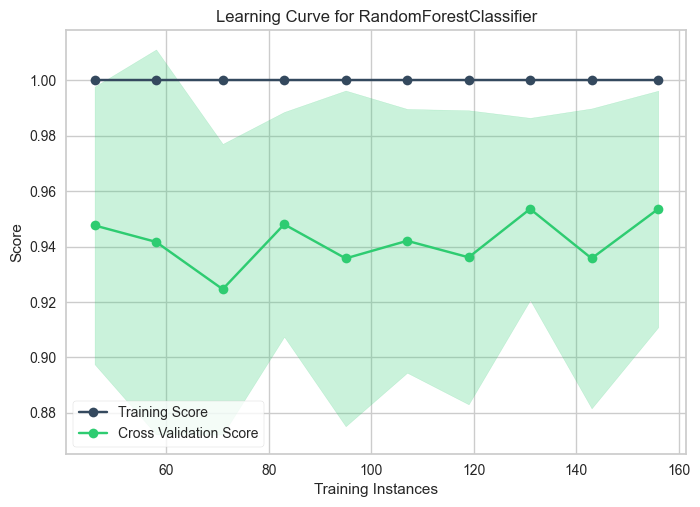

In [30]:
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Learning Curve
viz1 = LearningCurve(cls, cv=cv, scoring='f1_micro', train_sizes=sizes, n_jobs=4)
viz1.fit(features_train, labels_train)
viz1.set_title('Learning Curve') 
viz1.finalize()

The train curve and the cv curve fail to converge, this is expected from the results we already have. The model overfits the training data from the beginning, while with the cv data it fails to get better results, hovering around 94% f1. 

Let's see how it does on unseen data:

In [31]:
def test_model(model, features, labels, titles, is_binary=False):   
    for feature, label, title in zip(features, labels, titles):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create a 1x3 subplot grid

        cv = StratifiedKFold(n_splits=12)

        # # Learning Curve
        # viz1 = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, ax=axes[0],)
        # viz1.fit(feature, label)
        # axes[0].set_title('Learning Curve') 
        # viz1.finalize()

        # Validation Curve
        viz2 = ValidationCurve(
            model, param_name="max_depth",
            param_range=np.arange(1, 11), cv=cv, scoring="f1_weighted", ax=axes[0]
        )
        viz2.fit(feature, label)
        axes[0].set_title('Validation Curve')  
        viz2.finalize()
        

        # ROC AUC Curve
        viz3 = ROCAUC(model, classes=[0, 1, 2], binary=is_binary, ax=axes[1])
        viz3.fit(feature, label)
        viz3.score(feature, label)
        axes[1].set_title('ROC AUC Curve') 
        viz3.finalize()

        # Display legends only once at the end
        fig.suptitle(f'Metrics for {title}', fontsize=14)
        
        plt.tight_layout()
        plt.show()

    return None

Call the function on our different datasets:

> On the first graph the legend is wrong and I couldn't find a way currently to fix it. It is not the training score that is being shown, but the test and validation ones respectively.

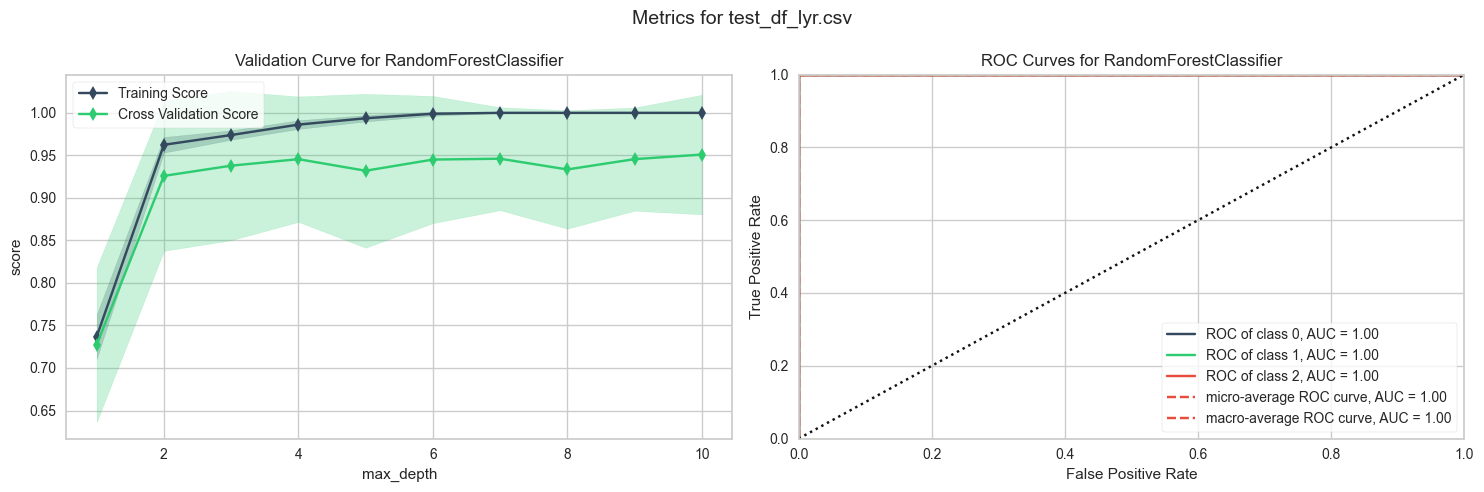

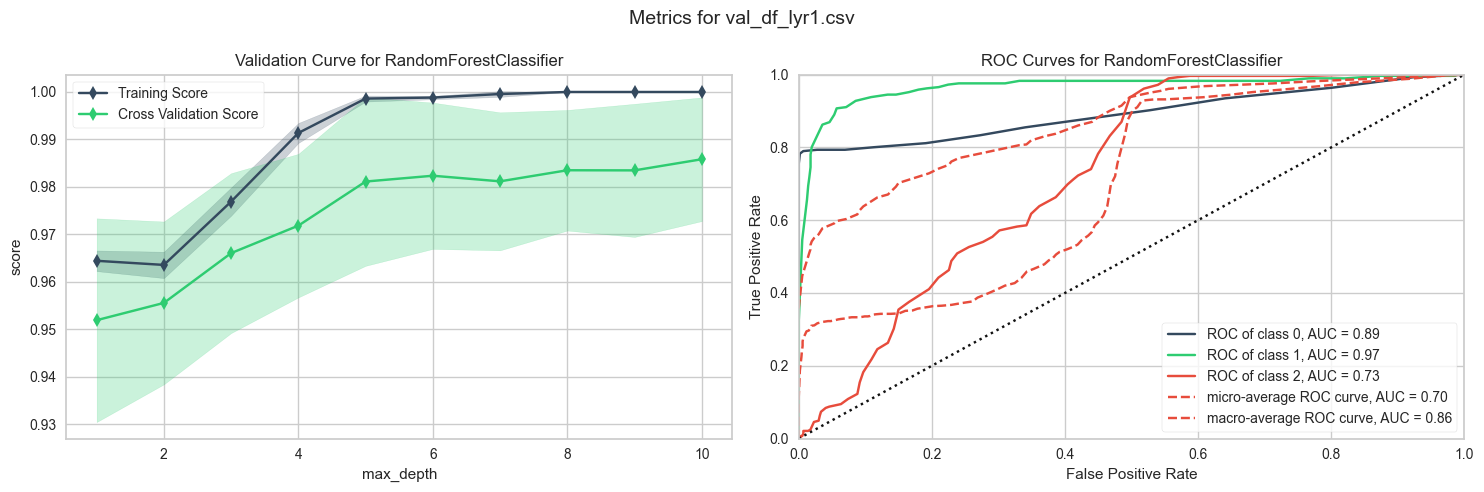

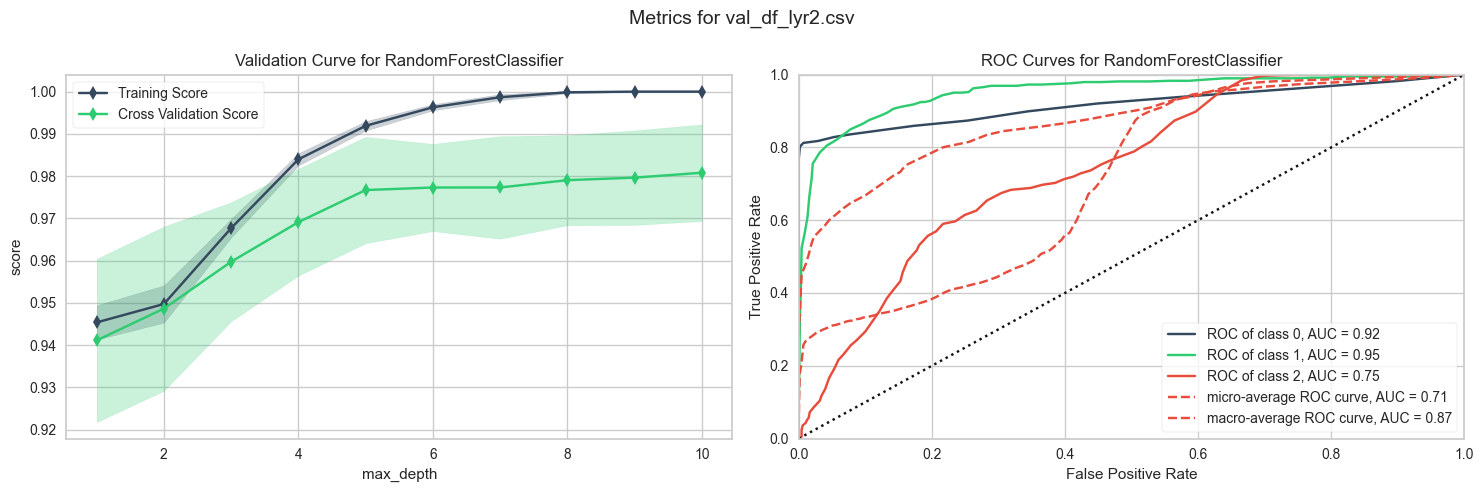

In [25]:
test_model(model = cls, features = [features_test, features_val, features_val2],
          labels = [labels_test, labels_val, labels_val2],
          titles = [title_test, title_val, title_val2])

From the validation curve we can see that the most optimal max_depth is 2 since there the two curves converge. Moreover from the ROC curve we menage to see that the model doesn't do very well with the RR Lyrae class. It is interesting to check if we can optimize the tree the underfit the data a little and check to see what we can do with the third class.

We wil call `GridSearchCV` and tune the classifier. Then test the best estimator chosen by `f1_micro`:

In [44]:
grid = GridSearchCV(
    rand_forest, param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [2],
    "min_samples_split": [5, 10, 12,],
    "min_samples_leaf": [1, 3, 5],
},
cv=5,
scoring='f1_micro'
)

In [45]:
grid.fit(features_train, labels_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [2, 5, 8], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [5, 10, 12],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_micro')

In [47]:
grid.fit(features_train, labels_train)
best_est = grid.best_estimator_
print(grid.best_params_)

{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


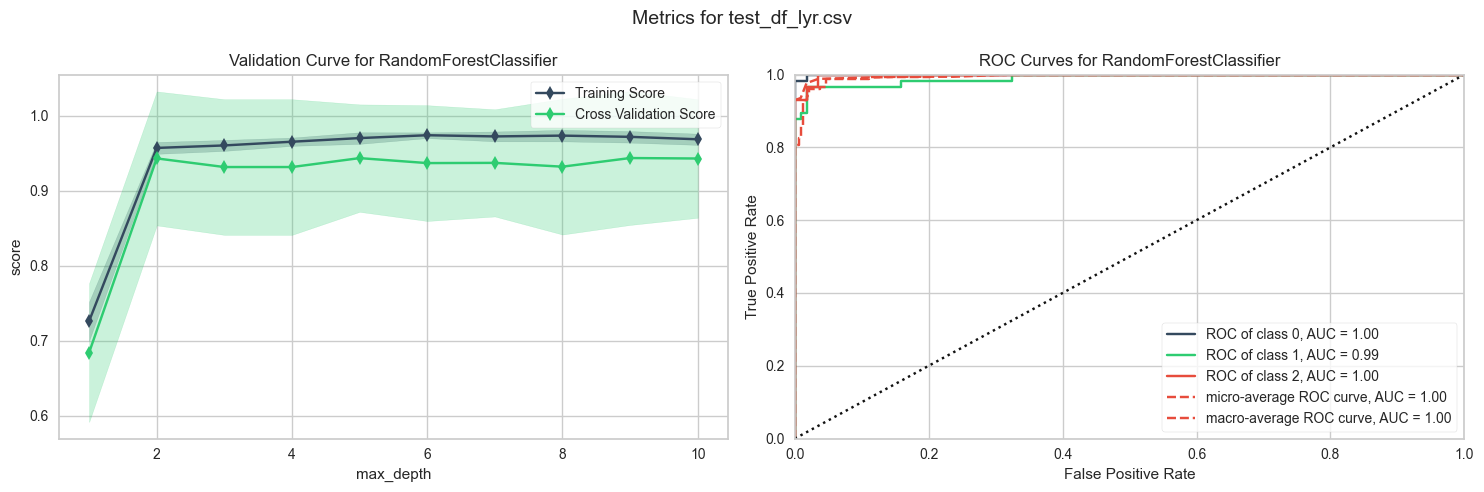

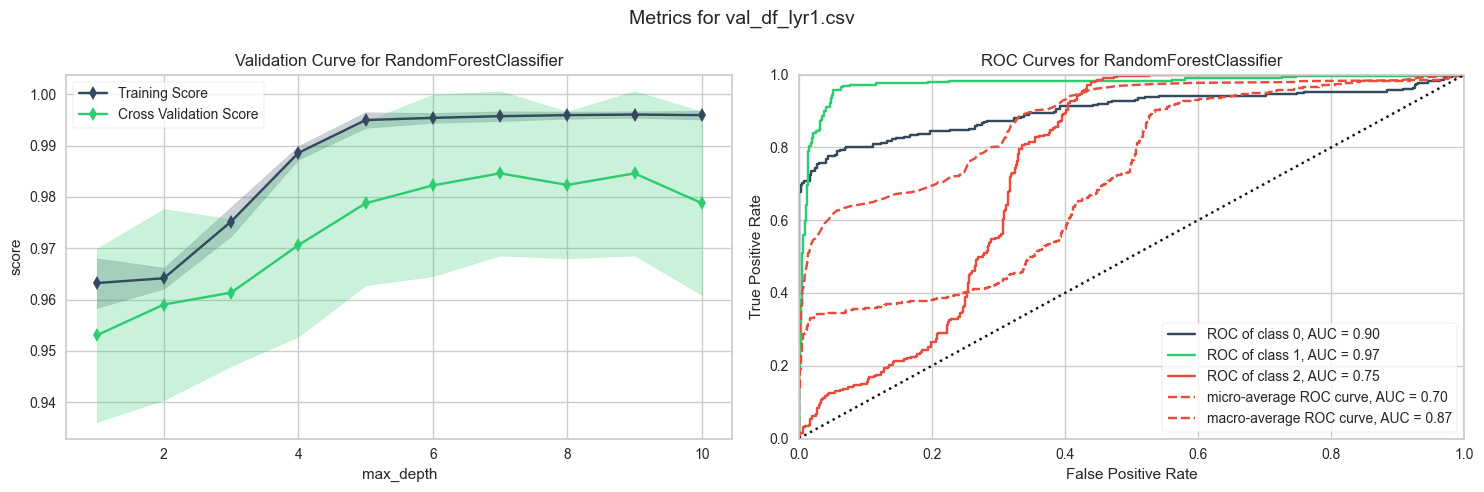

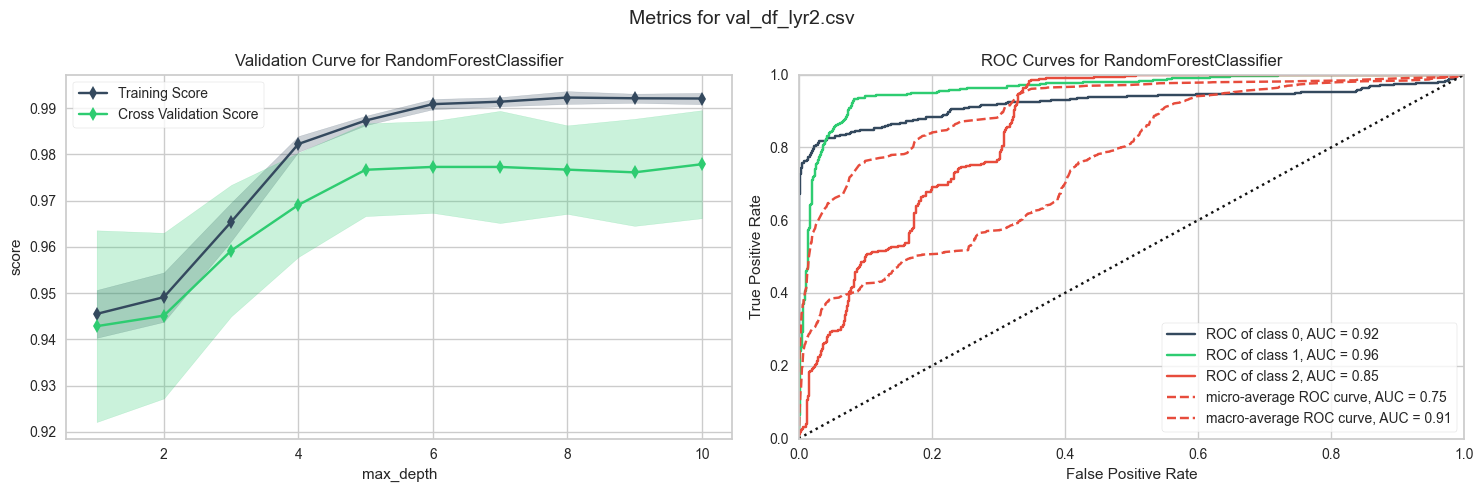

In [48]:
test_model(model = best_est, features = [features_test, features_val, features_val2],
          labels = [labels_test, labels_val, labels_val2],
          titles = [title_test, title_val, title_val2])

The result is not that great, except if we turn our attention to the both scores from `val_df_lyr2.csv` where the second model peforms 10% better (from 75% to 85%). Better results may come from using `RandomizedSearchCV`, but mainly we should train the model on more variety of data.

For now this model is far from the point of being used in real scenarios from the scientific community. It overfits the data which means in wont fare well with different datasets from different telescopes. 

## 5. Conclusion

I had a lot of struggles with the time series, and most of my time unfortunately went into troubleshooting and I wished I had more time playing around with the model and testing it.

## 6. References

- [Kim & Bailer-Jones (2015) Paper](https://arxiv.org/abs/1512.01611)
- [UPSILoN GitHub Repository](https://github.com/dwkim78/upsilon/tree/master)
- [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org/)
- [Nyquist Sampling Theorem - Google Search](https://www.google.com/search?q=nyquist&oq=nyquist&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIHCAcQABiABDIHCAgQABiABDIHCAkQABiABNIBCDE2MzVqMGoxqAIAsAIA&sourceid=chrome&ie=UTF-8)
- [OGLE Collection of Variable Stars (OCVS)](https://www.astrouw.edu.pl/ogle/ogle4/OCVS/gd/cep/)
- [OCVS - Photometric Data](https://www.astrouw.edu.pl/ogle/ogle4/OCVS/gd/cep/phot/I/)
- [OGLE Database](https://ogledb.astrouw.edu.pl/~ogle/OCVS/)
- [SIMBAD Astronomical Database](https://simbad.u-strasbg.fr/simbad/)
- [Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/#using-astroquery)
- [VizieR Astronomical Catalog Service - Google Search](https://www.google.com/search?q=vizier&oq=vizier&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIHCAcQABiABDIHCAgQABiABDIHCAkQABiABNIBCDExOTNqMGoxqAIAsAIA&sourceid=chrome&ie=UTF-8)
- [SDSS - Sloan Digital Sky Survey - Google Search](https://www.google.com/search?q=sloan+digital+sky+survey&oq=SLOAN+digital+&gs_lcrp=EgZjaHJvbWUqBwgAEAAYgAQyBwgAEAAYgAQyBggBEEUYOTIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIGCAcQRRg80gEIMzU4NWowajGoAgCwAgA&sourceid=chrome&ie=UTF-8)
- [VizieR Astronomical Catalog Service - Google Search](https://www.google.com/search?q=vizier&oq=vizier&gs_lcrp=EgZjaHJvbWUqCwgAEEUYJxg7GIoFMgsIABBFGCcYOxiKBTIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIGCAcQRRg80gEIMzU4NWowajGoAgCwAgA&sourceid=chrome&ie=UTF-8)
- [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)
- [Institute for Advanced Study - Criticism](https://en.wikipedia.org/wiki/Institute_for_Advanced_Study#Criticism)
- [Calmcode FAQ](https://calmcode.io/faq.html)
- [scikit-learn Stochastic Gradient Implementation](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_stochastic_gradient.py)
- [Using SGDClassifier with Partial Fit and Generators - Blog](https://jpinjpblog.wordpress.com/2019/04/16/using-sklearns-sgdclassifier-with-partial_fit-and-generators-gridsearchcv/)
- [SGDClassifier on Kaggle](https://www.kaggle.com/code/nsrose7224/sgdclassifier/notebook)
